In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Loading UK inflation rates

In [2]:
# Loading CSV file
file_path = 'Inflation_data.csv'
df = pd.read_csv(file_path, header=None)

# Drop empty rows
df.dropna(how='all', inplace=True)

# Rename columns manually
df.columns = ['Year', 'Inflation_Rate']

# Skip metadata rows (first few rows with titles)
inflation_data = df.iloc[7:].reset_index(drop=True)

# Clean inflation rate
inflation_data['Inflation_Rate'] = pd.to_numeric(inflation_data['Inflation_Rate'], errors='coerce')

# Convert Year to datetime
try:
    # Try converting as quarterly (e.g., "2022 Q1")
    inflation_data['Date'] = pd.PeriodIndex(inflation_data['Year'].str.replace(' ', ''), freq='Q').to_timestamp()
except:
    # Fallback to monthly (e.g., "2022 JAN")
    inflation_data['Date'] = pd.to_datetime(inflation_data['Year'], format='%Y %b', errors='coerce')

# Forward fill inflation rate
inflation_data['Inflation_Rate'] = inflation_data['Inflation_Rate'].ffill()

# Sort by Date
inflation_data = inflation_data.sort_values(by='Date').reset_index(drop=True)

# Save cleaned data
inflation_data.to_csv('UK_Inflation_Cleaned.csv', index=False)

# Show final output
print("\n Cleaned Inflation Data:")
inflation_data[['Date', 'Inflation_Rate']].head(10)


 Cleaned Inflation Data:


,Date,Inflation_Rate
0,1989-01-01,5.7
1,1989-02-01,5.8
2,1989-03-01,5.9
3,1989-04-01,5.6
4,1989-05-01,5.9
5,1989-06-01,5.8
6,1989-07-01,5.7
7,1989-08-01,5.5
8,1989-09-01,5.7
9,1989-10-01,5.8


# Loading cryptocurrency data

In [3]:
# Load the CSV file
btc_data = pd.read_csv('BTC_GBP_Historical_Data.csv', low_memory=False)

# Check for missing values
print("\nMissing values before cleaning:")
print(btc_data.isnull().sum())

# Drop rows with invalid dates
btc_data = btc_data.dropna(subset=['Date']).reset_index(drop=True)

# Recheck missing values
print("\nMissing values after dropping invalid dates:")
print(btc_data.isnull().sum())


# Define numeric columns
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Clean numeric columns
for col in numeric_cols:
    btc_data[col] = (
        btc_data[col].astype(str)
                     .str.replace(',', '', regex=True)
                     .replace('', 'NaN')
                     .astype(float)
    )

# Recheck missing values after cleaning
print("\nMissing values after cleaning numeric columns:")
print(btc_data.isnull().sum())

# Ensure all numeric columns are floats
btc_data[numeric_cols] = btc_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Save cleaned data
btc_data.to_csv('BTC_GBP_Cleaned.csv', index=False)

# Display cleaned data
btc_data.head()


Missing values before cleaning:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Missing values after dropping invalid dates:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Missing values after cleaning numeric columns:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


,Date,Open,High,Low,Close,Adj Close,Volume
0,"Jul 14, 2025",88266.31,91071.47,88110.45,89481.22,89481.22,1.324902e+11
1,"Jul 13, 2025",87086.71,87583.21,86662.43,87001.89,87001.89,3.372687e+10
2,"Jul 12, 2025",85407.86,87735.09,85031.73,87076.55,87076.55,6.441129e+10
3,"Jul 11, 2025",81871.49,85883.07,81640.85,85408.57,85408.57,7.062566e+10
4,"Jul 10, 2025",80198.41,82326.71,79832.30,81869.55,81869.55,4.259982e+10


# Merging two datasets

In [35]:
import pandas as pd

# 1. Load BTC-GBP data
btc_cleaned = pd.read_csv('BTC_GBP_Cleaned.csv')
btc_cleaned['Date'] = pd.to_datetime(btc_cleaned['Date'])
btc_cleaned = btc_cleaned.sort_values(by='Date').reset_index(drop=True)

# 2. Load inflation data
inflation_cleaned = pd.read_csv('UK_Inflation_Cleaned.csv')
inflation_cleaned['Date'] = pd.to_datetime(inflation_cleaned['Date'], errors='coerce')
inflation_cleaned = inflation_cleaned.dropna(subset=['Date']).sort_values(by='Date').reset_index(drop=True)

# 3. Merge using asof
merged_df = pd.merge_asof(btc_cleaned, inflation_cleaned[['Date', 'Inflation_Rate']], on='Date')

# 4. Forward fill inflation rate (to cover all days in a quarter/month)
merged_df['Inflation_Rate'] = merged_df['Inflation_Rate'].ffill()


# 6. Save final dataset
merged_df.to_csv('BTC_GBP_with_UK_Inflation.csv', index=False)
print("\n Merged dataset saved as 'BTC_GBP_with_UK_Inflation.csv'")

# 5. Show sample
print(" Final Merged Dataset Sample:")
merged_df[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Inflation_Rate']].head(10)


 Merged dataset saved as 'BTC_GBP_with_UK_Inflation.csv'
 Final Merged Dataset Sample:


,Date,Open,High,Low,Close,Adj Close,Volume,Inflation_Rate
0,2024-07-14,44617.23,46069.53,44530.71,45641.77,45641.77,1.316121e+10,3.1
1,2024-07-15,45636.61,47249.25,45636.61,46877.18,46877.18,1.713783e+10,3.1
2,2024-07-16,46898.51,50018.26,46827.30,50018.26,50018.26,2.937286e+10,3.1
3,2024-07-17,49952.16,50371.01,48179.85,50160.61,50160.61,3.206825e+10,3.1
4,2024-07-18,50156.51,50939.89,49132.26,49290.87,49290.87,2.500342e+10,3.1
5,2024-07-19,49280.07,50168.35,48874.61,49404.61,49404.61,2.103583e+10,3.1
6,2024-07-20,49403.27,52233.65,48935.09,51659.68,51659.68,2.865542e+10,3.1
7,2024-07-21,51659.50,52342.47,51327.44,51996.35,51996.35,1.473221e+10,3.1
8,2024-07-22,51997.33,52927.40,50971.42,52699.80,52699.80,2.060854e+10,3.1
9,2024-07-23,52698.61,52979.33,51586.99,52263.20,52263.20,3.298026e+10,3.1


# Exploratory data analysis

In [5]:
# Load merged dataset
merged_data = pd.read_csv('BTC_GBP_with_UK_Inflation.csv')

# Ensure 'Date' is in datetime format
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

# Set Date as index
merged_data.set_index('Date', inplace=True)

# Basic information and summary stats
print("📊 Dataset Info:")
print(merged_data.info())

print("\n📈 Summary Statistics:")
print(merged_data.describe())

# Check date range
print("\n📅 Date range of BTC prices:")
print(f"Start: {merged_data.index.min()}")
print(f"End: {merged_data.index.max()}")

# Check for missing values
print("\n❌ Missing Values:")
print(merged_data.isnull().sum())

📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-07-14 to 2025-07-14
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            366 non-null    float64
 1   High            366 non-null    float64
 2   Low             366 non-null    float64
 3   Close           366 non-null    float64
 4   Adj Close       366 non-null    float64
 5   Volume          366 non-null    float64
 6   Inflation_Rate  366 non-null    float64
dtypes: float64(7)
memory usage: 22.9 KB
None

📈 Summary Statistics:
               Open          High           Low         Close     Adj Close  \
count    366.000000    366.000000    366.000000    366.000000    366.000000   
mean   66123.745656  67355.064754  64936.663525  66242.417596  66242.417596   
std    13594.292640  13753.216077  13406.262394  13596.497507  13596.497507   
min    41082.180000  41752.830000  38611.300000  41081.920000  41081.92

# Visualizing Trends

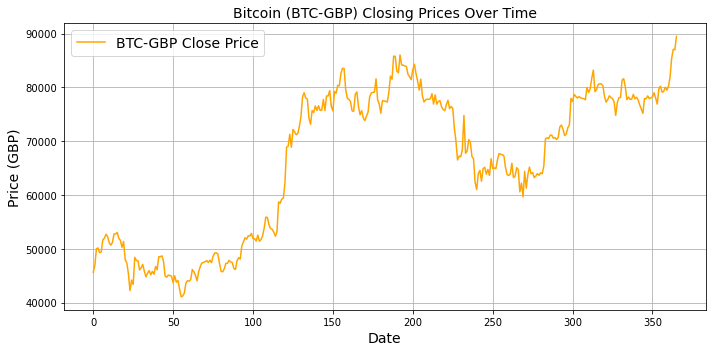

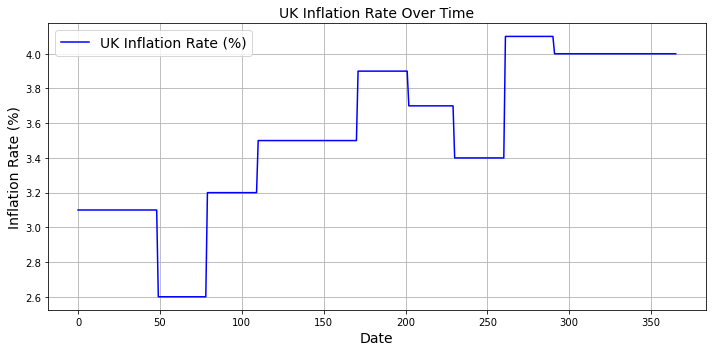

In [6]:
# Load merged dataset
merged_data = pd.read_csv('BTC_GBP_with_UK_Inflation.csv')

# Ensure Inflation_Rate is numeric
merged_data['Inflation_Rate'] = pd.to_numeric(merged_data['Inflation_Rate'], errors='coerce')

# Handle missing values
merged_data['Inflation_Rate'].fillna(method='ffill', inplace=True)
merged_data.dropna(subset=['Close'], inplace=True)

# Plot BTC Price Trends
plt.figure(figsize=(10, 5))
plt.plot(merged_data['Close'], label='BTC-GBP Close Price', color='orange')
plt.title('Bitcoin (BTC-GBP) Closing Prices Over Time', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (GBP)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Plot UK Inflation Rate Over Time
plt.figure(figsize=(10, 5))
plt.plot(merged_data.index, merged_data['Inflation_Rate'], label='UK Inflation Rate (%)', color='blue')
plt.title('UK Inflation Rate Over Time', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Inflation Rate (%)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


📊 Correlation Matrix:
                   Close  Inflation_Rate
Close           1.000000        0.801878
Inflation_Rate  0.801878        1.000000


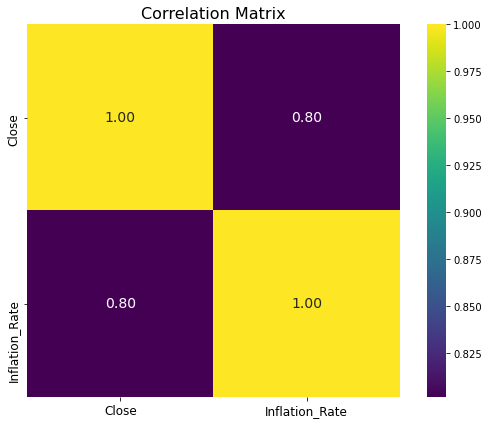

In [7]:
# Correlation Between BTC Price and Inflation Rate
numeric_cols = ['Close', 'Inflation_Rate']
correlation_matrix = merged_data[numeric_cols].corr()
print("\n📊 Correlation Matrix:")
print(correlation_matrix)

# Plotting correlation matrix p
plt.figure(figsize=(8, 6))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='viridis',  
    annot_kws={"fontsize": 14},  
    square=True, 
    cbar=True,  
    fmt=".2f"     
)
plt.title('Correlation Matrix', fontsize=16) 
plt.xticks(fontsize=12)  
plt.yticks(fontsize=12)  
plt.tight_layout()  
plt.show()

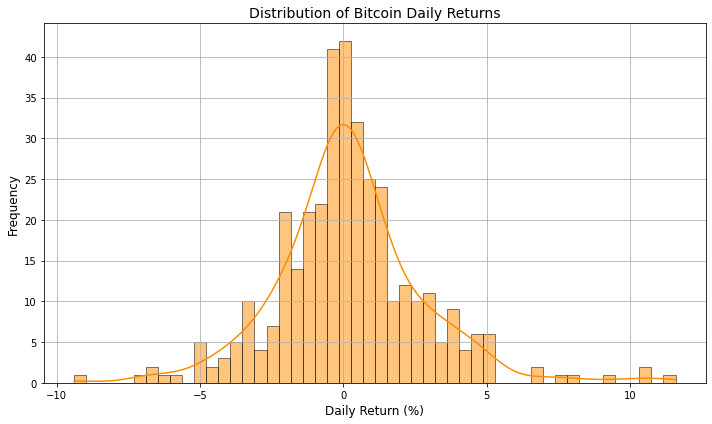

In [8]:
# Calculate Daily Returns
merged_data['Daily_Returns'] = merged_data['Close'].pct_change() * 100

# Plot Daily Returns
plt.figure(figsize=(10, 6))  
sns.histplot(
    merged_data['Daily_Returns'].dropna(),
    bins=50,
    kde=True,
    color='darkorange',  
    edgecolor='black',   
    linewidth=0.5      
)
plt.title('Distribution of Bitcoin Daily Returns', fontsize=14)  
plt.xlabel('Daily Return (%)', fontsize=12) 
plt.ylabel('Frequency', fontsize=12)  
plt.grid(True)
plt.tight_layout() 
plt.show()

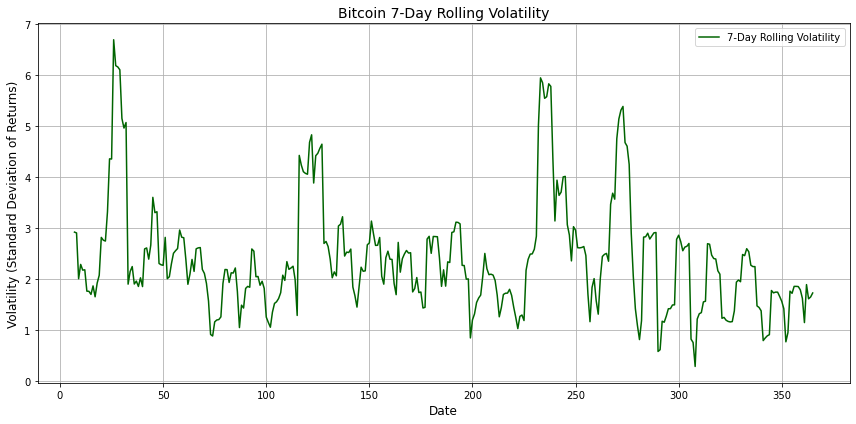

In [9]:
# Calculate Rolling Volatility
merged_data['Rolling_Volatility'] = merged_data['Daily_Returns'].rolling(window=7).std()

# Plot Rolling Volatility
plt.figure(figsize=(12, 6))  
plt.plot(
    merged_data.index,
    merged_data['Rolling_Volatility'],
    label='7-Day Rolling Volatility',
    color='darkgreen'
)
plt.title('Bitcoin 7-Day Rolling Volatility', fontsize=14)  
plt.xlabel('Date', fontsize=12) 
plt.ylabel('Volatility (Standard Deviation of Returns)', fontsize=12)  
plt.grid(True)
plt.legend(fontsize=10)  
plt.tight_layout()
plt.show()

# LSTM Model

x_train shape: (244, 60, 1)
y_train shape: (244, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 100)           40800     
                                                                 
 dropout_8 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71051 (277.54 KB)
Trainable params: 71051 (277.54 KB)
Non-trainable params: 0 (0.00 Byte)
______________________________

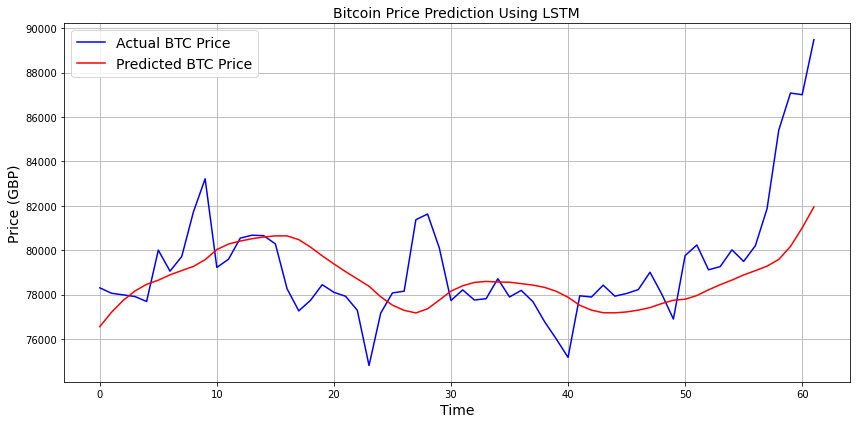

In [29]:
# Select Close price for forecasting (or add Inflation_Rate as feature if needed)
data = merged_data[['Close']].values

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(x), np.array(y)

SEQ_LENGTH = 60  # Use past 60 days to predict next day
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Show model summary
model.summary()

# Train the model
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test)

# Calculate evaluation metrics
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, color='blue', label='Actual BTC Price')
plt.plot(predicted_prices, color='red', label='Predicted BTC Price')
plt.title('Bitcoin Price Prediction Using LSTM', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (GBP)', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

x_train shape: (244, 60, 2)
y_train shape: (244,)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 60, 100)           41200     
                                                                 
 dropout_14 (Dropout)        (None, 60, 100)           0         
                                                                 
 lstm_15 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_15 (Dropout)        (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71451 (279.11 KB)
Trainable params: 71451 (279.11 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________

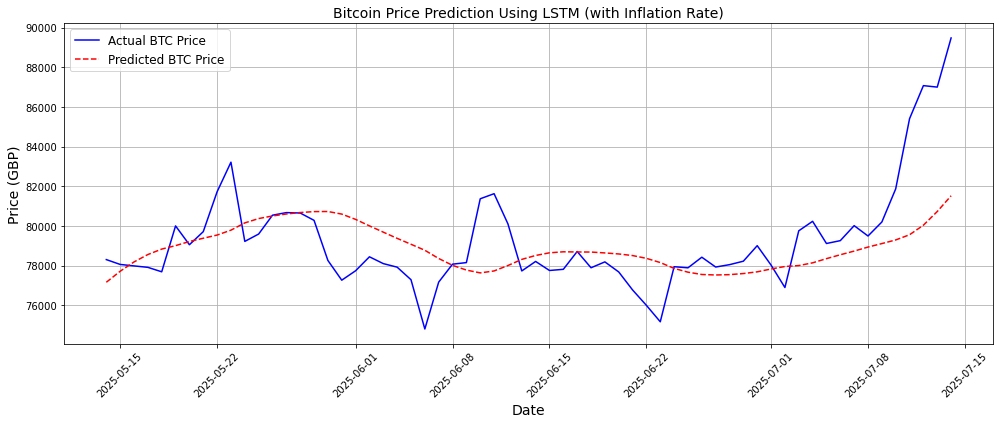

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load merged dataset (BTC price + UK inflation)
merged_data = pd.read_csv('BTC_GBP_with_UK_Inflation.csv')
merged_data['Date'] = pd.to_datetime(merged_data['Date'])
merged_data.set_index('Date', inplace=True)

# Select Close price and Inflation_Rate as features
data = merged_data[['Close', 'Inflation_Rate']].values

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i])  # past 60 days of [Close, Inflation]
        y.append(data[i, 0])           # next day's Close
    return np.array(x), np.array(y)

SEQ_LENGTH = 60
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

print("x_train shape:", x_train.shape)  # Should be (samples, 60, 2)
print("y_train shape:", y_train.shape)

# Build LSTM model with 2 features
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer predicts Close price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Show model summary
model.summary()

# Define callbacks for early stopping and learning rate reduction
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=50,  # Increased epochs but with early stop
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Make predictions
predicted_prices = model.predict(x_test)
predicted_prices = predicted_prices.flatten()  # Ensure same shape as y_test

# Rescale back to original values
# We need to reconstruct full sequence to inverse transform
dummy_array = np.zeros((len(predicted_prices), x_test.shape[2]))
dummy_array[:, 0] = predicted_prices.flatten()
predicted_prices_rescaled = scaler.inverse_transform(dummy_array)[:, 0]

dummy_array_ytest = np.zeros((len(y_test), x_test.shape[2]))
dummy_array_ytest[:, 0] = y_test
y_test_rescaled = scaler.inverse_transform(dummy_array_ytest)[:, 0]

# Calculate evaluation metrics
mse = mean_squared_error(y_test_rescaled, predicted_prices_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, predicted_prices_rescaled)
r2 = r2_score(y_test_rescaled, predicted_prices_rescaled)

print(f"\n📊 Model Accuracy Metrics (after adding inflation):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot predictions vs actuals
test_dates = merged_data.index[-len(y_test):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_rescaled, label='Actual BTC Price', color='blue')
plt.plot(test_dates, predicted_prices_rescaled, label='Predicted BTC Price', color='red', linestyle='--')
plt.title('Bitcoin Price Prediction Using LSTM (with Inflation Rate)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (GBP)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Hyperparamter Tuning

📊 Model Accuracy Metrics:
Mean Squared Error (MSE): 7098158.69
Root Mean Squared Error (RMSE): 2664.24
Mean Absolute Error (MAE): 1892.39
R² Score: -0.0328


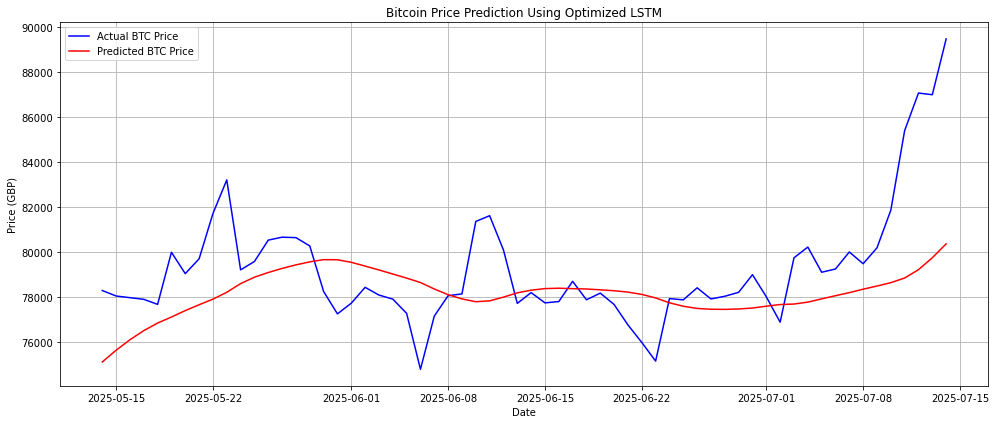

In [32]:
# Load merged dataset
merged_df = pd.read_csv('BTC_GBP_with_UK_Inflation.csv')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df.set_index('Date', inplace=True)

# Select features (Close price and Inflation Rate)
data = merged_df[['Close', 'Inflation_Rate']].values

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Predict BTC price (first column)
    return np.array(x), np.array(y)

SEQ_LENGTH = 60
x, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

# Define LSTM model
def build_lstm_model(units1=50, units2=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units1, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error'
    )
    return model

# Wrap model for scikit-learn
regressor = KerasRegressor(model=build_lstm_model, verbose=0)

# Define parameter grid
param_grid = {
    'model__units1': [50, 100],
    'model__units2': [50],
    'model__dropout_rate': [0.2],
    'model__learning_rate': [0.001],
    'batch_size': [32],
    'epochs': [10]
}

# Run GridSearchCV
grid = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_result = grid.fit(x_train, y_train)

# Get best model
best_model = grid_result.best_estimator_.model_

# Make predictions
y_pred = best_model.predict(x_test, verbose=0).flatten()

# Rescale predictions back to original scale
# We need to create dummy arrays to reverse the scaling
dummy_array = np.zeros((len(y_pred), 2))
dummy_array[:, 0] = y_pred.flatten()
y_pred_actual = scaler.inverse_transform(dummy_array)[:, 0]

dummy_array_test = np.zeros((len(y_test), 2))
dummy_array_test[:, 0] = y_test
y_test_actual = scaler.inverse_transform(dummy_array_test)[:, 0]

# Calculate accuracy metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

# Print metrics
print("📊 Model Accuracy Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot predictions vs actuals
test_dates = merged_df.index[-len(y_test):]

plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_actual, label='Actual BTC Price', color='blue')
plt.plot(test_dates, y_pred_actual, label='Predicted BTC Price', color='red')
plt.title('Bitcoin Price Prediction Using Optimized LSTM')
plt.xlabel('Date')
plt.ylabel('Price (GBP)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# GARCH Model

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                      GARCH   Log-Likelihood:               -851.076
Distribution:                  Normal   AIC:                           1708.15
Method:            Maximum Likelihood   BIC:                           1719.84
                                        No. Observations:                  364
Date:                Tue, Jul 15 2025   Df Residuals:                      364
Time:                        09:15:09   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.9855      0.476      2.069  3.854e-02 [5.194e-0

<Figure size 864x432 with 0 Axes>

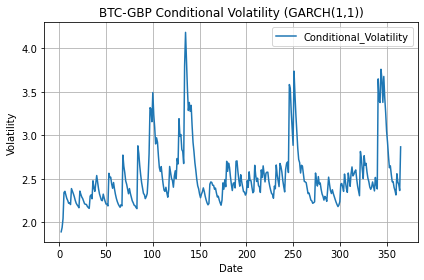

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


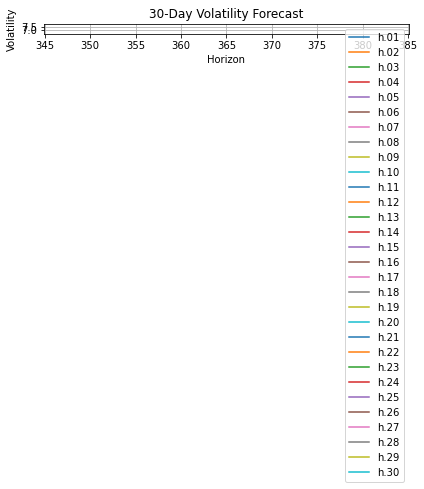

In [26]:
# Calculate daily returns
btc_data['Returns'] = btc_data['Close'].pct_change() * 100  # Convert to percentage
btc_data.dropna(inplace=True)

#fit the GARCH model
garch_model = arch_model(
    btc_data['Returns'],
    mean='Zero',  # Zero-mean assumption
    vol='GARCH',
    p=1,          # AR order
    o=0,          # No exogenous variables
    q=1,
    dist='Normal'
)

# Fit the model
res = garch_model.fit(disp='off')

# Print summary
print(res.summary())

# Plot conditional volatility
vol_forecast = res._volatility
volatility_df = pd.DataFrame({
    'Date': btc_data.index,
    'Conditional_Volatility': vol_forecast
}).set_index('Date')

# Plot volatility
plt.figure(figsize=(12, 6))
volatility_df.plot(title='BTC-GBP Conditional Volatility (GARCH(1,1))')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

# Forecast future volatility
forecast = res.forecast(horizon=30)
forecast_vol = forecast.variance[-1:]  # Get last variance forecast
forecast_vol.plot(title='30-Day Volatility Forecast')
plt.xlabel('Horizon')
plt.ylabel('Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

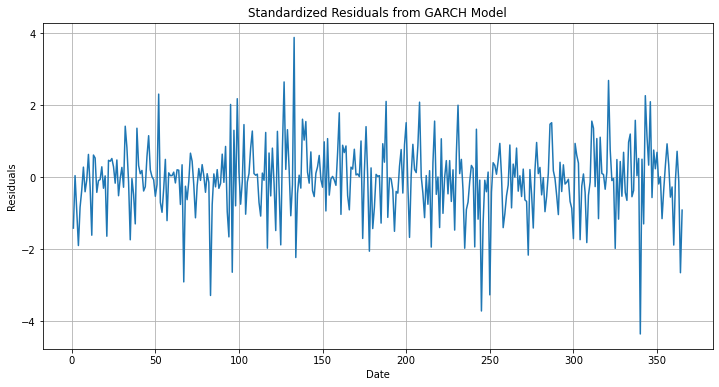

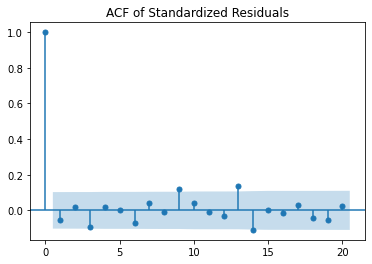

In [20]:
# Get standardized residuals
std_resid = res.resid / res.conditional_volatility

# Plot standardized residuals
plt.figure(figsize=(12, 6))
plt.plot(std_resid)
plt.title("Standardized Residuals from GARCH Model")
plt.xlabel("Date")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# Check for autocorrelation in residuals
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(std_resid, lags=20)
plt.title("ACF of Standardized Residuals")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


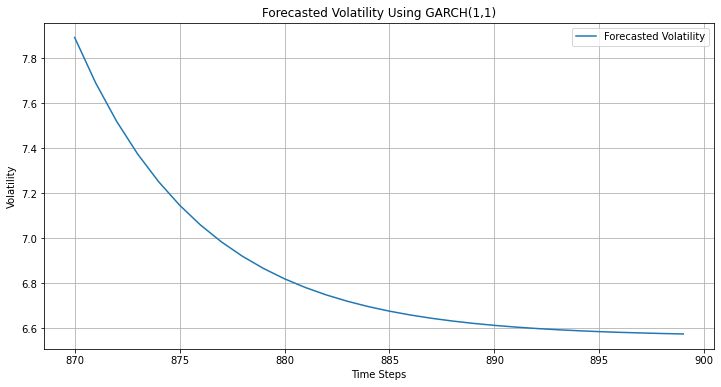

In [25]:
# Forecast future volatility
forecast_horizon = 30  # Number of days to forecast
forecast = res.forecast(horizon=forecast_horizon)

# Plot forecasted volatility
plt.figure(figsize=(12, 6))
plt.plot(forecast.variance.iloc[-forecast_horizon:].values.flatten(), label='Forecasted Volatility')
plt.title("Forecasted Volatility Using GARCH(1,1)")
plt.xlabel("Time Steps")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()